# IQ Mixing notes

https://markimicrowave.com/technical-resources/application-notes/how-to-think-about-iq-mixers/

In [6]:
%matplotlib widget
import niscope as ni

# Uscita trigger dal signal generator: Pulse Sync

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import h5py
import time
import numpy as np

import sys
sys.path.insert(1, '..\\Instruments\\network\\Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')
sys.path.insert(3, '..\\Instruments\\QuickSyn')

import RS_SMA100B
from Card_Class import *
from HDF5 import save_dict_to_hdf5 as hdf5_write

import FSL_0010

#fsl = FSL_0010.FSL10_synthesizer(device_address='COM31')

ModuleNotFoundError: No module named 'serial'

In [3]:
ip              = '192.168.40.15'            # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

k = 3           # coefficiente per prendere k*1000 punti con la scheda, dunque devo aumentare la pulse width e period

pulse_freq      = 0.010e9
amplitude       = -24                                               # Set the amplitude of the signal in dBm
sample_rate     = 250e6                                             # Maximum Value: 250.0e6
pulse_width     = k * 3e-6                                          # min 5ns                             
pulse_delay     = 0
pulse_period    = k * 5e-6                                          # min 20ns


sGen.reset()
sGen.clear()
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('SING')
sGen.RF_freq(pulse_freq)
sGen.RF_lvl_ampl(amplitude)


# parameters for the Acquisition Card
pxie.voltage_range      = 0.5
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = 1000
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = sample_rate                               # Maximum Value: 250.0e6

NameError: name 'RS_SMA100B' is not defined

In [3]:
pxie.open(port = 1)


pota        = np.arange(amplitude, amplitude + 25 , 1)
pula        = np.arange(pulse_freq, pulse_freq + 0.025e9, 0.001e9)
amplidick   = {}
counter     = 1

for p, pot in enumerate(pota):

    amplidick[f'p{zero+p}'] = {'power_(dBm)': pot, 'freqs': {}}
    sGen.RF_lvl_ampl(pot)

    for i, pul in enumerate(pula):
        
        sGen.RF_freq(pul) # guarda come è definito, abbiamo messo la potenza e6   
        sGen.pul_state(1)
        sGen.RF_state(1)
        # time.sleep(0.1)
        waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)
        I = np.array(waveforms[3].samples.tolist())
        Q = np.array(waveforms[2].samples.tolist())
        # if p == 1 and i == 1:
        #   plt.clf()
        #   #plt.plot(np.sqrt(I**2 + Q**2))
        #   plt.plot(np.arctan(Q/I))
        #   plt.show()
        
        
        sGen.pul_state(0)
        sGen.RF_state(0)

        print(int(counter*100/(len(pota)*len(pula))),'%')
        counter += 1
        amplidick[f'p{digits_p.format(p)}']['freqs'][f'f{digits_f.format(i)}'] = {'freq_(Hz)': pul, 'I': I, 'Q': Q}
fsl.set_output('OFF')


# SAVE DATA ON HDF5 FILE
filename = 'amplitrix.h5'
if os.path.exists("demofile.txt"):
  os.remove("demofile.txt")
hdf5_write(amplidick, filename)

AcquisitionStatus.COMPLETE
0.16 %
AcquisitionStatus.COMPLETE
0.32 %
AcquisitionStatus.COMPLETE
0.48 %
AcquisitionStatus.COMPLETE
0.64 %
AcquisitionStatus.COMPLETE
0.8 %
AcquisitionStatus.COMPLETE
0.96 %
AcquisitionStatus.COMPLETE
1.12 %
AcquisitionStatus.COMPLETE
1.28 %
AcquisitionStatus.COMPLETE
1.44 %
AcquisitionStatus.COMPLETE
1.6 %
AcquisitionStatus.COMPLETE
1.76 %
AcquisitionStatus.COMPLETE
1.92 %
AcquisitionStatus.COMPLETE
2.08 %
AcquisitionStatus.COMPLETE
2.24 %
AcquisitionStatus.COMPLETE
2.4 %
AcquisitionStatus.COMPLETE
2.56 %
AcquisitionStatus.COMPLETE
2.72 %
AcquisitionStatus.COMPLETE
2.88 %
AcquisitionStatus.COMPLETE
3.04 %
AcquisitionStatus.COMPLETE
3.2 %
AcquisitionStatus.COMPLETE
3.36 %
AcquisitionStatus.COMPLETE
3.52 %
AcquisitionStatus.COMPLETE
3.68 %
AcquisitionStatus.COMPLETE
3.84 %
AcquisitionStatus.COMPLETE
4.0 %
AcquisitionStatus.COMPLETE
4.16 %
AcquisitionStatus.COMPLETE
4.32 %
AcquisitionStatus.COMPLETE
4.48 %
AcquisitionStatus.COMPLETE
4.64 %
AcquisitionStatus.C

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'amplitrix.h5'

In [ ]:
# Turn ON the modulation of the Signal Generator
# sGen.pul_state(1)
# sGen.RF_state(1)


# FSL-0010
# fsl.set_frequency(1) # GHz
# fsl.set_output('ON')




with ni.Session("PXI1Slot3") as session: # Name of the device
    session.reset_with_defaults()
    session.channels[0].configure_vertical(range=2.0, coupling=ni.VerticalCoupling.AC) # I
    session.channels[2].configure_vertical(range=2.0, coupling=ni.VerticalCoupling.AC) # Q
    session.configure_horizontal_timing(
        min_sample_rate     = 250e6, 
        min_num_pts         = int(1000*k), 
        ref_position        = 0, 
        num_records         = 1, 
        enforce_realtime    = True
        )

    session.configure_trigger_digital(
        trigger_source      = 'VAL_PFI_0', 
        slope               = ni.TriggerSlope.POSITIVE, 
        holdoff             = 0, 
        delay               = 0
        )

    with session.initiate():
        waveforms = session.channels[0, 2].fetch()
        #waveforms = session.channels[0].fetch()
    for wfm in waveforms:
        print('Channel {0}, record {1} samples acquired: {2:,}\n'.format(wfm.channel, wfm.record, len(wfm.samples)))
        print('Channel {0}, record {1} samples acquired: {2:,}\n'.format(wfm.channel, wfm.record, len(wfm.samples)))

fsl.set_output('OFF')
sGen.pul_state(0)
sGen.RF_state(0)

a = np.array(waveforms[0].samples.tolist())
b = np.array(waveforms[1].samples.tolist())


plt.figure()
#plt.plot(np.arange(len(a))/250e6, 20*np.log10(np.array(a)**2 + np.array(b)**2))
plt.plot(np.arange(len(a))/250e6, np.sqrt(np.array(a)**2 + np.array(b)**2))
#plt.plot(np.arange(len(a))/250e6, np.arctan(np.array(b)/np.array(a)))
#plt.plot(np.arange(len(a))/250e6, np.array(a))
plt.show()

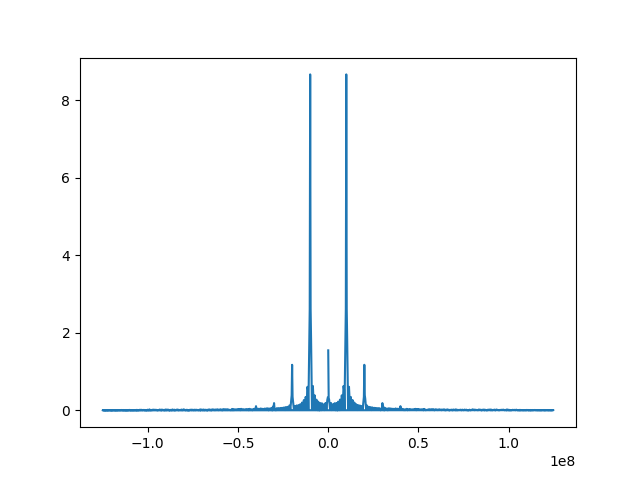

In [40]:
def weight_factor (ft, range_mask):
    # tot_int = np.trapz(ft)
    tot_int = np.sum(ft)
    ft[~range_mask] = 0
    # portion = np.trapz(ft)
    portion = np.sum(ft)

    return tot_int/portion

def data_fft(y: np.array, freq, sample_rate, toggle_plot = True):
    N = len(y)
    T = 1/sample_rate
    FT = np.fft.fft(y)
    PHI = np.unwrap(np.angle(FT))

    x = np.arange(len(y))/sample_rate
    freqs = np.fft.fftfreq(N,T) 
    offset = 5e6

    if toggle_plot:
        plt.clf()
        
       
        plt.plot(freqs,np.abs(FT))
        plt.show()
    
data_fft(a, 80e6, sample_rate, True)

- [x] Nel grafico sopra, la frequenza del sig gen è 1,020 GHz. Si notano i due picchetti di 40 = 2 * 20 MHz, ma paiono estremamente piccoli. (Foto sul telefono per il futuro)

Dai test sembra che non servano attenuazioni quando il segnale passa per il mixer, ma è necessaerio capire quanta potenza effettivamente arriva alla scheda per non friggerla.

## DOVREMO fare la CARATTERIZZAZIONE DELL'IQ-MIXER

Studiare range di ampiezze in cui opera e magari anhe range di frequenze.
Studiare Attenuazione che dà?

Nel piano I-q non compare una circonferenza precisa, ma è più un'ellisse. Studiare e magari richiedere.

## LA PRESA DATI PROBABILMENTE SARA' A GIUGNO (2 SETTIMANE CENTRALI)

Preparare i programmi, anche per l'analisi dati in loco per risparmiare tempo.
Relazione su Latex
Giachero dice di premere per fare presa dati a maggio piuttosto che a giugno, ma francamente la vedo dura.
# Sistemare i cicli for nei programmi!! e ritestare il single trigger nei for.